In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from stacked_classifier import StackedPredictionCV
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
#skin dataset - 3 features and 1 target
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00229/Skin_NonSkin.txt'
skin_data_raw = pd.read_csv(url,sep='\t',names=['x1','x2','x3','target'])

In [163]:
print(skin_data_raw['target'].unique())
skin_data_raw['target']=skin_data_raw['target'].map({1:0,2:1})
skin_data_raw.head()

[1 2]


,x1,x2,x3,target
0,74,85,123,0
1,73,84,122,0
2,72,83,121,0
3,70,81,119,0
4,70,81,119,0


In [164]:
skin_data_raw['target'].unique()

array([0, 1], dtype=int64)

In [165]:
X = skin_data_raw.values[:,:3]
y = skin_data_raw.values[:,3]

In [166]:
#X_test,y_test used for final model evaluation
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=1)

In [167]:
lm = LogisticRegression()
lm.fit(X_train,y_train)
y_pred_lm = lm.predict(X_test)
y_pred_proba_lm = lm.predict_proba(X_test)[:,1]
fpr_lm, tpr_lm, thresh = roc_curve(y_test,y_pred_proba_lm)
roc_lm = auc(fpr_lm, tpr_lm)

In [168]:
rf = RandomForestClassifier(n_estimators=100,max_depth=3)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresh = roc_curve(y_test,y_pred_proba_rf)
roc_rf = auc(fpr_rf, tpr_rf)

In [169]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train,y_train)
y_pred_dt = dt.predict(X_test)
y_pred_proba_dt = dt.predict_proba(X_test)[:,1]
fpr_dt, tpr_dt, thresh = roc_curve(y_test,y_pred_proba_dt)
roc_dt = auc(fpr_dt, tpr_dt)

In [149]:
#Training a stacked model which uses actual predicted values in the second level

#level one stacked model
model_list = [lm,rf,dt]
stacked_model = StackedPredictionCV(model_list)
stacked_model.fit_transform(X_train,y_train)
y_pred_stacked = stacked_model.predict()
y_pred_proba_stacked = stacked_model.predict_proba()
target_y = stacked_model.actual_target()

#training the second level model #logistic Regression
lm = LogisticRegression()
lm.fit(y_pred_stacked,target_y)

#processing the X_test values through the stack
model_preds,model_preds_proba = stacked_model.transform(X_test)

#predicting with the linear model
y_pred_lm_stacked = lm.predict(model_preds)
y_pred_proba_lm_stacked = lm.predict_proba(model_preds)[:,1]
fpr_lms, tpr_lms, thresh = roc_curve(y_test,y_pred_proba_lm_stacked)
roc_lms = auc(fpr_lms, tpr_lms)

In [156]:
#Training a stacked model which uses probabilities in the second level

#level one stacked model
model_list = [lm,rf,dt]
stacked_model = StackedPredictionCV(model_list)
stacked_model.fit_transform(X_train,y_train)
y_pred_stacked = stacked_model.predict()
y_pred_proba_stacked = stacked_model.predict_proba()
target_y = stacked_model.actual_target()

#training the second level model #logistic Regression
lm = LogisticRegression()
lm.fit(y_pred_proba_stacked,target_y)

#processing the X_test values through the stack
model_preds,model_preds_proba = stacked_model.transform(X_test)

#predicting with the linear model
y_pred_lm_stacked = lm.predict(model_preds_proba)
y_pred_proba_lm_stacked_proba = lm.predict_proba(model_preds)[:,1]
fpr_lmsp, tpr_lmsp, thresh = roc_curve(y_test,y_pred_proba_lm_stacked_proba)
roc_lmsp = auc(fpr_lmsp, tpr_lmsp)

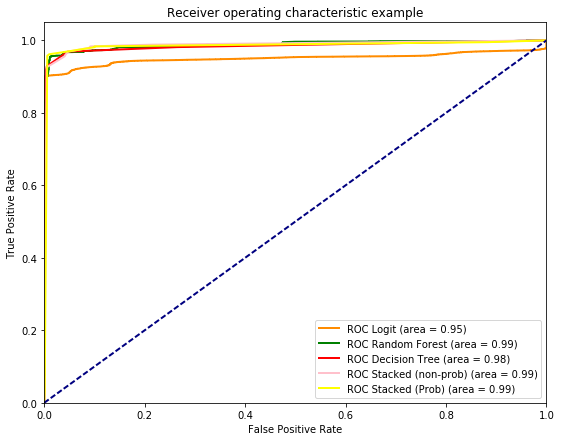

In [157]:
plt.figure(figsize=(9,7))
lw = 2
plt.plot(fpr_lm, tpr_lm, color='darkorange', lw=lw, label='ROC Logit (area = %0.2f)' %roc_lm)
plt.plot(fpr_rf, tpr_rf, color='green', lw=lw, label='ROC Random Forest (area = %0.2f)' %roc_rf)
plt.plot(fpr_dt, tpr_dt, color='red', lw=lw, label='ROC Decision Tree (area = %0.2f)' %roc_dt)
plt.plot(fpr_lms, tpr_lms, color='pink', lw=lw, label='ROC Stacked (non-prob) (area = %0.2f)' %roc_lms)
plt.plot(fpr_lmsp, tpr_lmsp, color='yellow', lw=lw, label='ROC Stacked (Prob) (area = %0.2f)' %roc_lmsp)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle= '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()